# Baseline

The task is to predict fish's weight based on metric parameters such as length, width etc. We focus here only on maximizing R^2 score as this is the metric stated for this competition.

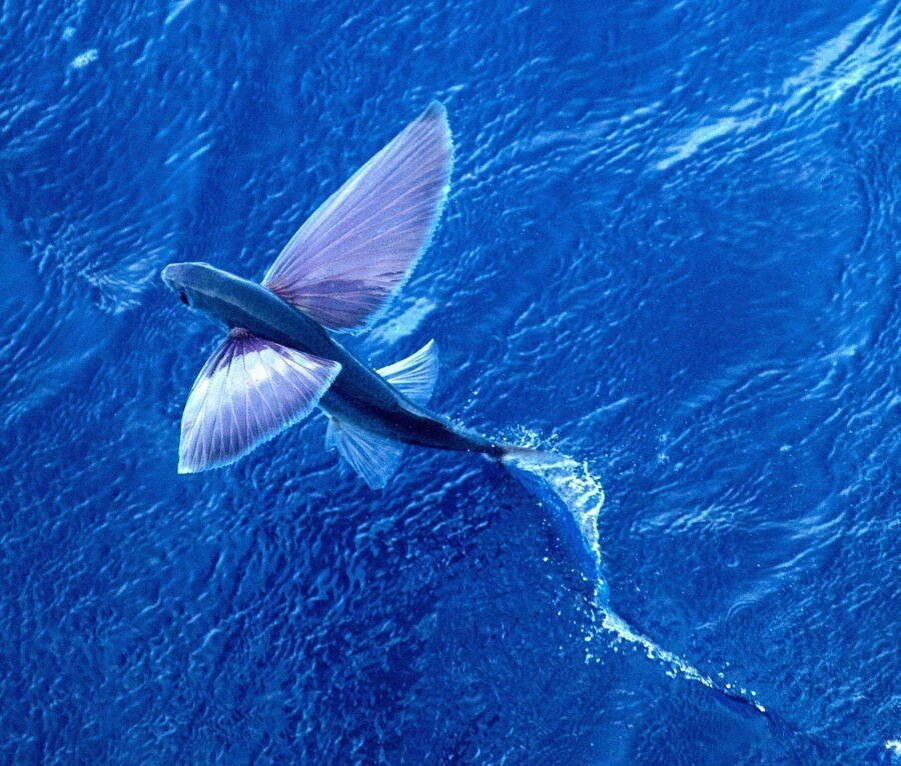

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Let's inspect our data.

In [31]:
TrainData = pd.read_csv("https://raw.githubusercontent.com/aiedu-courses/all_datasets/main/TrainDataFlight.csv")
TrainData.head()

,Species,Length1,Length2,Length3,Height,Width,Weight
0,Cypselurus,35.0,38.5,44.1,18.0369,6.3063,920.0
1,Hirundichthys,10.0,10.5,11.6,1.9720,1.1600,7.5
2,Cypselurus,23.9,26.5,31.1,12.3778,4.6961,340.0
3,Exocoetus,24.0,26.0,29.2,8.8768,4.4968,290.0
4,Parexocoetus,18.4,20.0,22.4,8.8928,3.2928,150.0


In [32]:
TrainData.shape

(119, 7)

In [33]:
TrainData.columns

Index(['Species', 'Length1', 'Length2', 'Length3', 'Height', 'Width',
       'Weight'],
      dtype='object')

In [34]:
TrainData["Species"].value_counts()

Cheilopogon      41
Cypselurus       28
Exocoetus        16
Fodiater         14
Parexocoetus     10
Hirundichthys     8
Prognichthys      2
Name: Species, dtype: int64

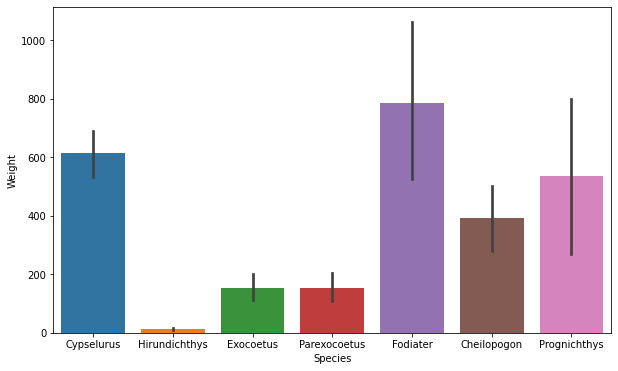

In [35]:
plt.pyplot.figure(figsize = (10, 6))
sns.barplot(x = "Species", y = "Weight", data = TrainData)
plt.pyplot.show()

Species


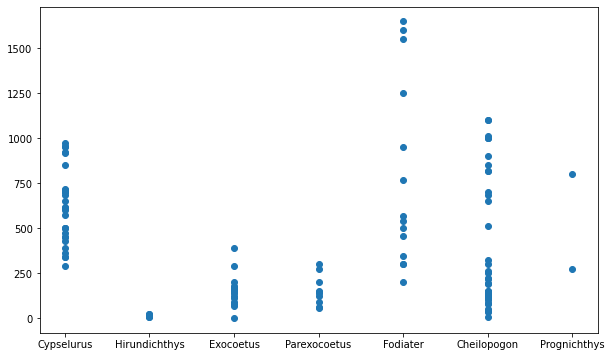

Length1


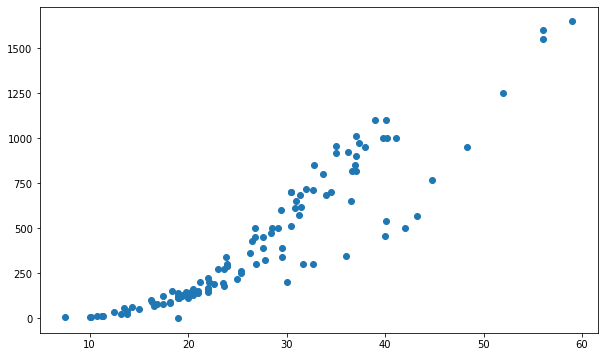

Length2


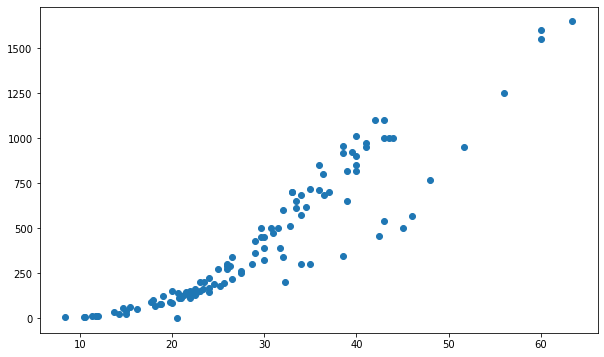

Length3


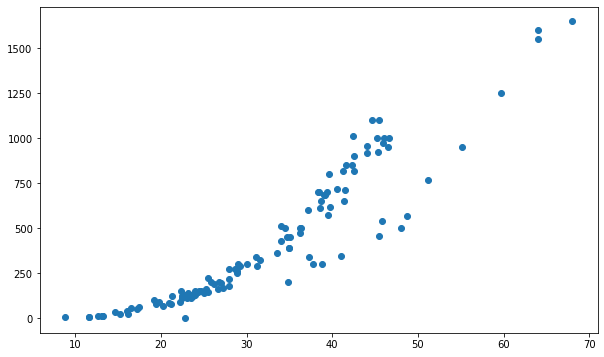

Height


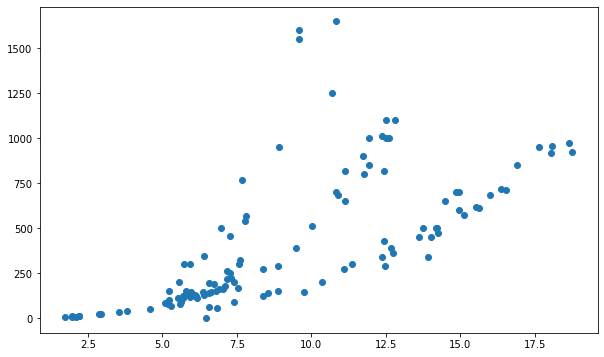

Width


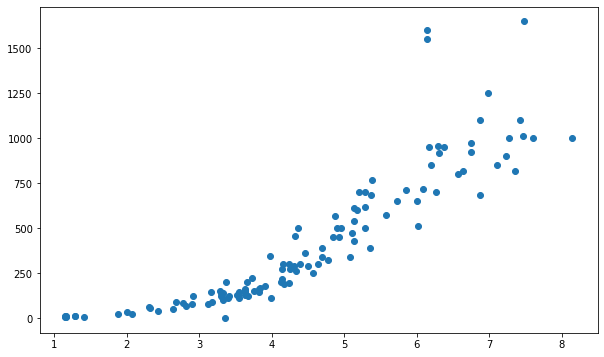

Weight


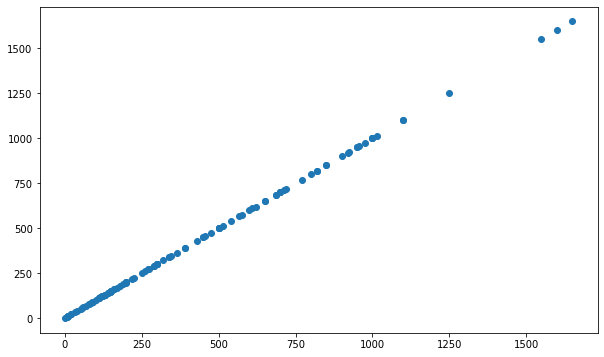

In [36]:
for c in TrainData.columns:
    print(c)
    plt.pyplot.figure(figsize = (10, 6))
    plt.pyplot.scatter(TrainData[c], TrainData["Weight"])
    plt.pyplot.show()

We have somewhat parabole distribution for metric features. Let's get dummies for species and linearize distribution for metric features using logarithms. We take average for length as we don't know what actually Length 1, 2, 3 are and suppose that their average exposes length of a fish. We also want to capture cross effects of metric parameters, so we include paired products of length, height, width.

In [37]:
TrainData_enc = pd.get_dummies(TrainData, columns = ["Species"], drop_first = True, dtype = int)
TrainData_enc.head()

,Length1,Length2,Length3,Height,Width,Weight,Species_Cypselurus,Species_Exocoetus,Species_Fodiater,Species_Hirundichthys,Species_Parexocoetus,Species_Prognichthys
0,35.0,38.5,44.1,18.0369,6.3063,920.0,1,0,0,0,0,0
1,10.0,10.5,11.6,1.9720,1.1600,7.5,0,0,0,1,0,0
2,23.9,26.5,31.1,12.3778,4.6961,340.0,1,0,0,0,0,0
3,24.0,26.0,29.2,8.8768,4.4968,290.0,0,1,0,0,0,0
4,18.4,20.0,22.4,8.8928,3.2928,150.0,0,0,0,0,1,0


In [38]:
TrainData_enc["Length"] = (TrainData_enc["Length1"] + TrainData["Length2"] + TrainData["Length3"]) / 3
TrainData_enc.drop(["Length1", "Length2", "Length3"], inplace = True, axis = 1)

However, we have observations with 0 weight and with identical values of explanatory variables but different weight. These are obviously mistakes, so let's delete them from our data.

In [39]:
X = TrainData.drop(['Weight'], axis=1)
y = TrainData['Weight']

In [40]:
Z = X[X.duplicated(keep=False) == True]
Z

,Species,Length1,Length2,Length3,Height,Width
66,Fodiater,56.0,60.0,64.0,9.6,6.144
70,Fodiater,56.0,60.0,64.0,9.6,6.144


In [41]:
TrainData_enc = TrainData_enc[TrainData_enc["Weight"] > 0]
TrainData_enc = TrainData_enc.drop(index=70)
TrainData_enc

,Height,Width,Weight,Species_Cypselurus,Species_Exocoetus,Species_Fodiater,Species_Hirundichthys,Species_Parexocoetus,Species_Prognichthys,Length
0,18.0369,6.3063,920.0,1,0,0,0,0,0,39.200000
1,1.9720,1.1600,7.5,0,0,0,1,0,0,10.700000
2,12.3778,4.6961,340.0,1,0,0,0,0,0,27.166667
3,8.8768,4.4968,290.0,0,1,0,0,0,0,26.400000
4,8.8928,3.2928,150.0,0,0,0,0,1,0,20.266667
...,...,...,...,...,...,...,...,...,...,...
114,8.5376,3.2944,140.0,0,0,0,0,1,0,20.966667
115,14.4738,5.7276,650.0,1,0,0,0,0,0,34.400000
116,6.1100,3.4075,120.0,0,0,0,0,0,0,21.833333
117,7.6156,4.7716,320.0,0,0,0,0,0,0,29.800000


In [42]:
TrainData_enc["Height"] = np.log(TrainData_enc["Height"])
TrainData_enc["Width"] = np.log(TrainData_enc["Width"])
TrainData_enc["Weight"] = np.log(TrainData_enc["Weight"])
TrainData_enc["Length"] = np.log(TrainData_enc["Length"])

In [43]:
TrainData_enc["LW"] = TrainData_enc["Length"] * TrainData_enc["Width"]
TrainData_enc["LH"] = TrainData_enc["Length"] * TrainData_enc["Height"]
TrainData_enc["WH"] = TrainData_enc["Width"] * TrainData_enc["Height"]

Height


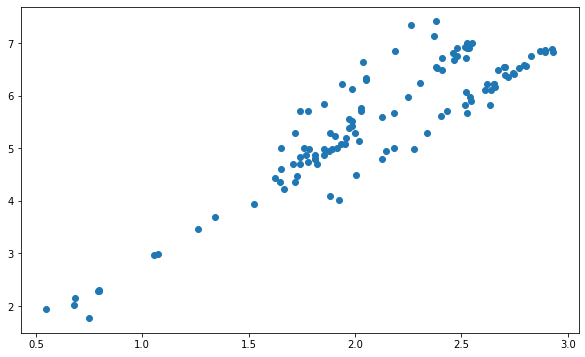

0.9078943488686898
Width


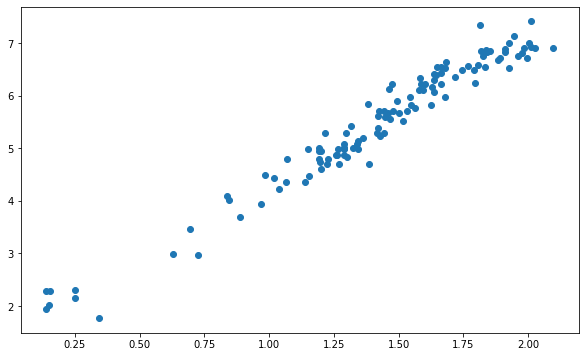

0.9792498004883231
Weight


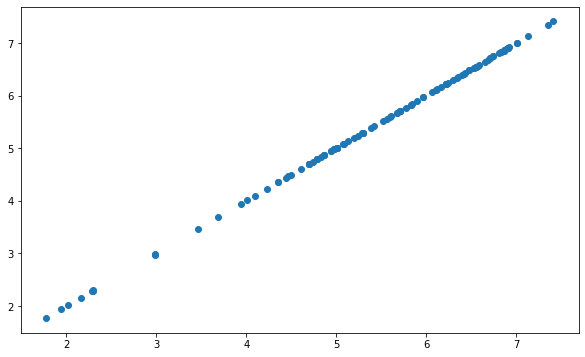

1.0
Species_Cypselurus


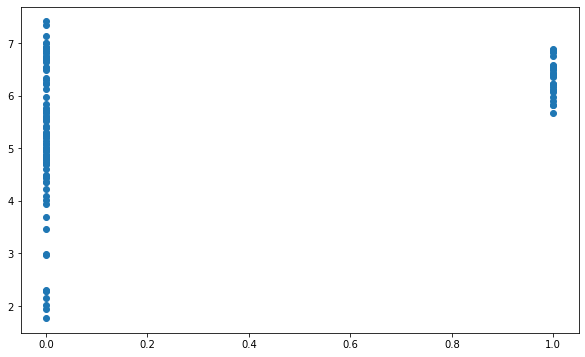

0.3981685061658398
Species_Exocoetus


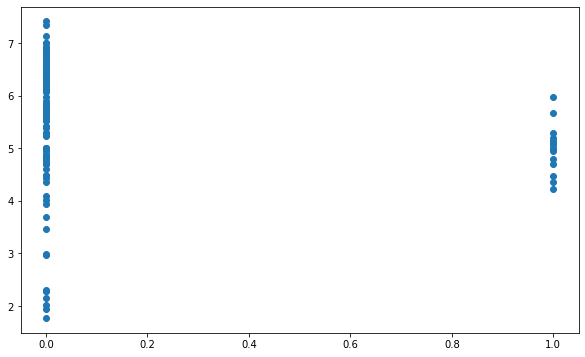

-0.14189780089315782
Species_Fodiater


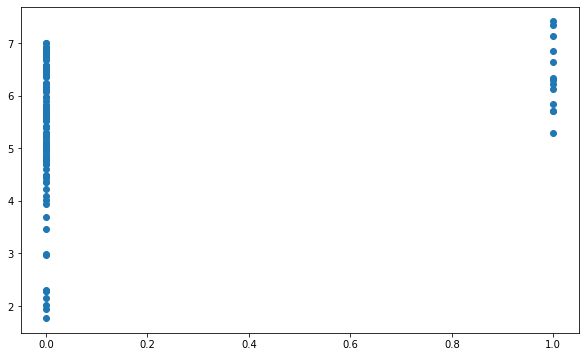

0.25533557179960187
Species_Hirundichthys


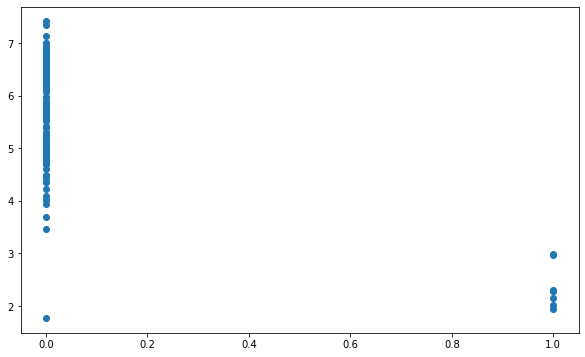

-0.6602053901611215
Species_Parexocoetus


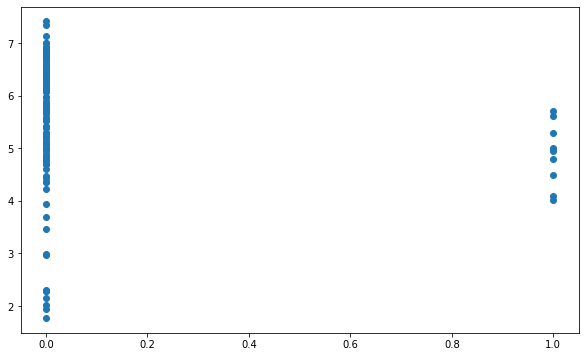

-0.1371189189969953
Species_Prognichthys


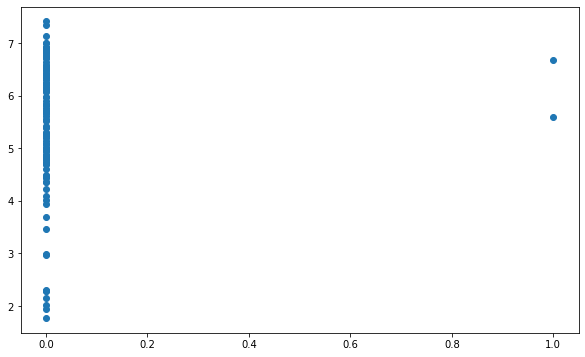

0.07070375761048447
Length


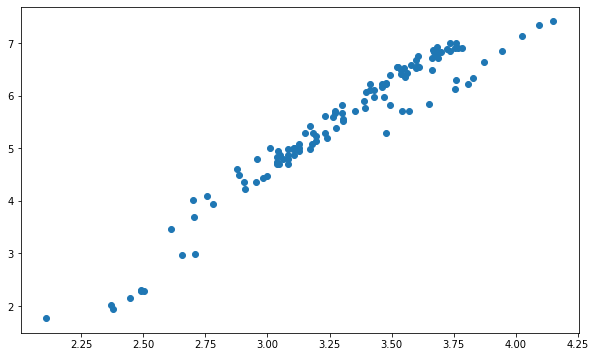

0.9650033385372357
LW


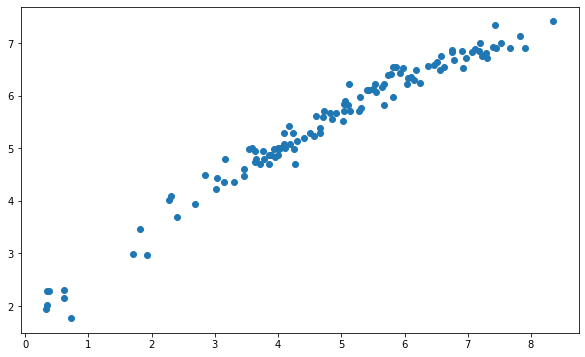

0.9799432503922046
LH


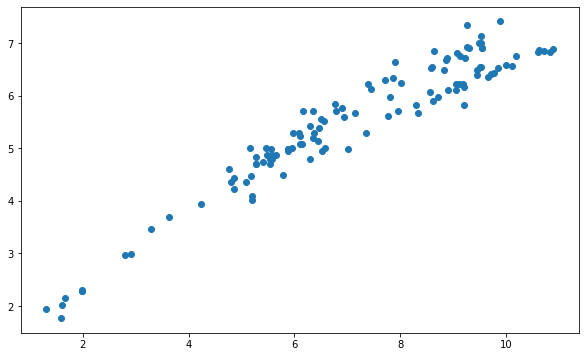

0.9579329393580477
WH


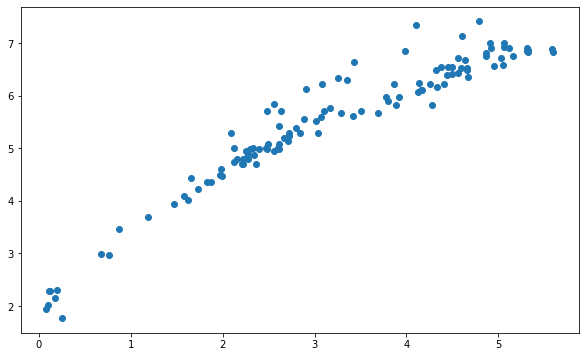

0.9500571348508088


In [44]:
for c in TrainData_enc.columns:
    print(c)
    plt.pyplot.figure(figsize = (10, 6))
    plt.pyplot.scatter(TrainData_enc[c], TrainData_enc["Weight"])
    plt.pyplot.show()
    print(np.corrcoef(TrainData_enc[c], TrainData_enc["Weight"])[0][1])

As we see distributions became more like linear ones.

In [45]:
TrainData_enc.head()

,Height,Width,Weight,Species_Cypselurus,Species_Exocoetus,Species_Fodiater,Species_Hirundichthys,Species_Parexocoetus,Species_Prognichthys,Length,LW,LH,WH
0,2.892420,1.841549,6.824374,1,0,0,0,0,0,3.668677,6.756048,10.611353,5.326533
1,0.679048,0.148420,2.014903,0,0,0,1,0,0,2.370244,0.351792,1.609510,0.100784
2,2.515905,1.546732,5.828946,1,0,0,0,0,0,3.301991,5.107296,8.307493,3.891431
3,2.183441,1.503366,5.669881,0,1,0,0,0,0,3.273364,4.921064,7.147198,3.282511
4,2.185242,1.191738,5.010635,0,0,0,0,1,0,3.008978,3.585914,6.575344,2.604236


Now we are ready to build a model. I tried many models but got best scores with ridge regression, so here I show realization of this model.

In [46]:
X = TrainData_enc.drop(['Weight'], axis=1)
y = TrainData_enc['Weight']

In [47]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)

Xtrain.shape, Xtest.shape

((87, 12), (30, 12))

In [48]:
scaler = StandardScaler()
model = Ridge(alpha = 0.01)
pipeline = Pipeline([("scaler", scaler), ("ridge", model)])
pipeline.fit(Xtrain, ytrain)

Pipeline(steps=[('scaler', StandardScaler()), ('ridge', Ridge(alpha=0.01))])

In [49]:
pred = pipeline.predict(Xtest)
r2_score(ytest, pred)

0.9972126263098191

In [50]:
pred_train = pipeline.predict(Xtrain)
r2_score(ytrain, pred_train)

0.9945588430084725

In [51]:
np.exp(pred)

array([ 165.05356149,  138.24046992,   59.70806267,  559.08147082,
        635.60039249, 1131.78750212,  114.27461626,  168.75657277,
        290.91734022,  131.0513223 ,   96.13212639,  507.09893867,
        164.07724935,  643.25936752,   86.98063103,  927.4210992 ,
       1079.88700369,  142.2777382 ,  891.84423462,    8.72768661,
        202.83768405,   39.70219633,  319.2510357 ,  117.66812093,
         10.02970018,  377.14400635,  230.9274861 ,  822.89848646,
       1152.68150147,   22.80419   ])

In [52]:
weights = pd.DataFrame(X.columns, model.coef_)
weights

,0
0.621484,Height
0.094336,Width
-0.063211,Species_Cypselurus
-0.024906,Species_Exocoetus
-0.049693,Species_Fodiater
-0.055898,Species_Hirundichthys
-0.019612,Species_Parexocoetus
0.011206,Species_Prognichthys
0.785306,Length
0.128109,LW


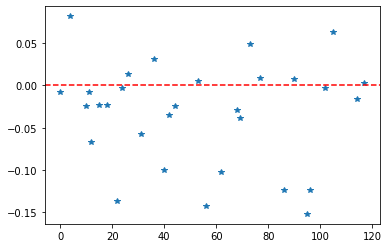

In [53]:
plt.pyplot.plot(ytest - pred, "*")
plt.pyplot.axhline(y=0, color='red', linestyle='--')

# Uploading the solution

Now we need to send our predictions to checking system to see the score on the test set not used for training and validation. We first need to replicate all stages made with features on train dataset.

In [54]:
TestData = pd.read_csv("https://raw.githubusercontent.com/aiedu-courses/all_datasets/main/TestDataFlight.csv")

TestData.head()

,Species,Length1,Length2,Length3,Height,Width
0,Hirundichthys,9.3,9.8,10.8,1.7388,1.0476
1,Fodiater,34.8,37.3,39.8,6.2884,4.0198
2,Parexocoetus,19.0,20.7,23.2,9.3960,3.4104
3,Cheilopogon,34.6,37.0,39.3,10.5717,6.3666
4,Exocoetus,21.1,22.5,25.0,6.4000,3.8000


In [55]:
Test = pd.get_dummies(TestData, columns=['Species'], drop_first=True, dtype=int)

In [56]:
Test["Length"] = (Test["Length1"] + Test["Length2"] + Test["Length3"]) / 3

In [57]:
Test["Height"] = np.log(Test["Height"])
Test["Width"] = np.log(Test["Width"])
Test["Length"] = np.log(Test["Length"])

In [58]:
Test["LW"] = Test["Length"] * Test["Width"]
Test["LH"] = Test["Length"] * Test["Height"]
Test["WH"] = Test["Width"] * Test["Height"]
Test.drop(["Length1", "Length2", "Length3"], inplace = True, axis = 1)

Test.head()

,Height,Width,Species_Cypselurus,Species_Exocoetus,Species_Fodiater,Species_Hirundichthys,Species_Parexocoetus,Species_Prognichthys,Length,LW,LH,WH
0,0.553195,0.046502,0,0,0,1,0,0,2.299246,0.106919,1.271932,0.025725
1,1.838707,1.391232,0,0,1,0,0,0,3.618993,5.034860,6.654267,2.558068
2,2.240284,1.226830,0,0,0,0,1,0,3.042934,3.733161,6.817036,2.748447
3,2.358181,1.851066,0,0,0,0,0,0,3.610017,6.682377,8.513071,4.365147
4,1.856298,1.335001,0,1,0,0,0,0,3.129680,4.178126,5.809619,2.478160


In [59]:
pred_test = np.exp(pipeline.predict(Test))

In [60]:
pred_test

array([  5.45716599, 331.29548261, 155.39171557, 681.32859711,
       146.07634563, 675.80239043,  11.97355789, 559.78858512,
       728.83642656,  11.88513496, 339.92303563, 707.2783683 ,
       694.49359257,  88.83950174, 245.7400504 ,  10.70423484,
       470.03652746, 179.51799731,  35.77534868, 126.63674855,
       404.58497227, 921.82274543, 158.51525851, 270.6014618 ,
       297.71503984, 486.92974342, 278.47528618, 587.46641802,
       281.22618687, 845.82950576,   9.10366446,  64.58178647,
       957.94548985,   8.87896298, 111.79464272, 130.49558187,
       732.86036541, 580.6948735 ,  90.19779359, 268.75732929])

In [61]:
Test['predictions'] = pred_test

Test.head()

,Height,Width,Species_Cypselurus,Species_Exocoetus,Species_Fodiater,Species_Hirundichthys,Species_Parexocoetus,Species_Prognichthys,Length,LW,LH,WH,predictions
0,0.553195,0.046502,0,0,0,1,0,0,2.299246,0.106919,1.271932,0.025725,5.457166
1,1.838707,1.391232,0,0,1,0,0,0,3.618993,5.034860,6.654267,2.558068,331.295483
2,2.240284,1.226830,0,0,0,0,1,0,3.042934,3.733161,6.817036,2.748447,155.391716
3,2.358181,1.851066,0,0,0,0,0,0,3.610017,6.682377,8.513071,4.365147,681.328597
4,1.856298,1.335001,0,1,0,0,0,0,3.129680,4.178126,5.809619,2.478160,146.076346


In [104]:
Test[['predictions']].to_csv("Final.csv", columns = ["predictions"], index = False)